# Final Project. Communities and Crime

The objective of this project is to predict the _ViolentCrimesPerPop_ quantity which ilustrates the number of violent crimes per 100k population.

## Import all necessary packages

In [31]:
import pandas as pd
import numpy as np
import pygwalker as pyg
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

## Exploring and Cleaning Data

### Extract columns names from _communities.names_

In [32]:
with open("communities.names") as NamesFile:
    Lines = NamesFile.readlines()[75:203]
ColumnsNames = [Line.split()[1] for Line in Lines]

### Read data from _communities.data_

In [33]:
Data = pd.read_csv("communities.data", index_col=False, names=ColumnsNames)
# Check if DataFrame looks ok...
Data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


For easier data manipulation, we will make a copy of the whole DataFrame without the _communityname_ column.

In [34]:
NewData = Data.drop(["communityname"], axis=1)
NewData

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,1,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,1,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,1,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,10,0.01,0.40,0.10,0.87,0.12,0.16,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,10,0.05,0.96,0.46,0.28,0.83,0.32,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,10,0.16,0.37,0.25,0.69,0.04,0.25,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,10,0.08,0.51,0.06,0.87,0.22,0.10,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [35]:
# General info about the data
NewData.info()
# Getting number of communities
n_communities = len(NewData)
print(f"\nTotal of communities: {n_communities}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 127 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(25)
memory usage: 1.9+ MB

Total of communities: 1994


### Dropping columns with deficient total data
Some columns might have half or more of the total data as non-defined, all these written as a "?", so we will drop the columns that might not help us for the analysis.

In [36]:
with open("DeficientColumnsData.csv", "w") as DefData:
    HalfNumCommunities = n_communities//2
    for ColumnName in NewData.columns:
        # Get number of "?" in given column and check if it is more or equal than the
        # total of communties
        Total_UnknownDataColumn = (NewData[ColumnName] == "?").sum()
        if Total_UnknownDataColumn >= HalfNumCommunities:

            DefData.write(f"{ColumnName},{Total_UnknownDataColumn}\n")
            NewData.drop(labels=[ColumnName], axis=1, inplace=True)

print(NewData.info())
NewData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(1)
memory usage: 1.6+ MB
None


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


### Exploring isolated non-defined data
Now we will check if there is still columns with strings or non-numerical data in them.

In [37]:
NewData.dtypes[NewData.dtypes != "int64"][NewData.dtypes != "float64"]

OtherPerCap    object
dtype: object

We can see that _OtherPerCap_ column has object dtype so let's observe the head column.

In [38]:
NewData.OtherPerCap.head()

0    0.36
1    0.22
2    0.28
3    0.36
4    0.51
Name: OtherPerCap, dtype: object

It seems we have numerical data so let's search for any non-numerical data in it.

In [39]:
def CheckFloat(x):
    try:
        y = float(x)
        return True
    except ValueError:
        return False
    
Rows_NonNum_OtherPerCap = list( Data.OtherPerCap.index[NewData.OtherPerCap.apply(CheckFloat) == False])
Data.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"]

130    ?
Name: OtherPerCap, dtype: object

There is only data with a non-numeric value, so we decided to replace it with the mean value.

In [40]:
# Replacing OtherPerPop in index 130 with the mean of the available data
def GetMean_PrevOtherPerPop(Data):
    Sum = 0.0
    Values = Data.OtherPerCap.values
    for Val in Values:
        try:
            Sum += float(Val)
        except ValueError:
            pass
    return Sum/len(Values)

NewData.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"] = GetMean_PrevOtherPerPop(NewData)
NewData = NewData.astype({"OtherPerCap":"float64"})
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(101), int64(2)
memory usage: 1.6 MB


### Getting final DataFrame
For the final DataFrame, we will also drop the _state_ and _fold_ columns since they are categorical data

In [41]:
NewData.drop(["state", "fold"], axis=1, inplace=True)
 
print(NewData.info())
NewData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, population to ViolentCrimesPerPop
dtypes: float64(101)
memory usage: 1.5 MB
None


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


## Exploratory Data Analysis

### EDA Univar

In [42]:
#def UniVarEDAGraphs(x):
#    NewData[x].hist()
#    plt.title("histogram of "+x)
#    plt.show()
    
#def UniVarEDADescribe(x):
#    mean_ = NewData[x].mean()
#    std_ = NewData[x].std()
#    median_ = NewData[x].median()
#    print("============================================================================================")
#    print("Description of "+x+":")
#    print("Mean: "+ str(mean_)+" - Std Dev: "+ str(std_)+" - Median: "+str(median_))

GRAPHS:

In [43]:
#for x in NewData.columns:
#    UniVarEDAGraphs(x)

DESCRIPTIONS:

In [44]:
#for x in NewData.columns:
#    UniVarEDADescribe(x)

### EDA Bivariate

In [45]:
#def BiVarEDAGraphs(x_,y_):
#    NewData.plot.scatter(x=x_,y=y_)
#    plt.title("Scatter Plot of "+x_+" vs "+y_)
#    plt.show()
    
#def BiVarEDADesc(x,y):
#    print("The correlation between"+x+" and"+y+" is "+str(NewData.corr()[x].loc[y]))

racepctblack vs racepPctWhite

In [46]:
#BiVarEDAGraphs("racepctblack","racePctWhite")
#BiVarEDADesc("racepctblack","racePctWhite")

### EDA to target variable

In [47]:
CorrMap = NewData.corr()

#def EDATargetGraph(x_):
#    NewData.plot.scatter(x=x_,y="ViolentCrimesPerPop")
#    plt.title("Scatter Plot of "+x_+" vs ViolentCrimesPerPop - Corr: "+str(CorrMap[x_]["ViolentCrimesPerPop"].round(2)))
#    plt.show()

In [48]:
#for col in NewData.columns:
#    EDATargetGraph(col)

### Correlation MAP

<AxesSubplot: >

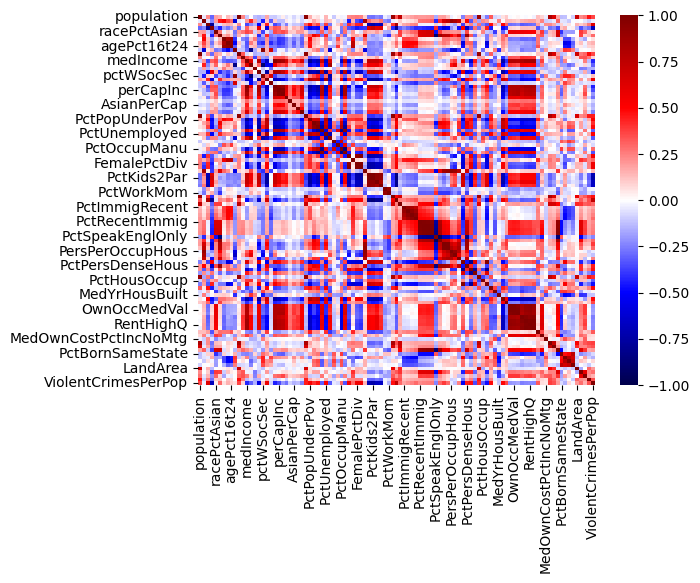

In [49]:
sns.heatmap(CorrMap, vmin=-1, vmax=1, cmap="seismic", annot=False)

## Principal Components Analysis
The objective of applying this methodology is to identify and visualize the weights of each variable, or column, of our dataset.

In [50]:
N_variables = len(NewData.columns)
PCA_Data = PCA(n_components=N_variables)
PCA_Data.fit(NewData)

PCA(n_components=101)

In [51]:
PCA_Data.explained_variance_ratio_

array([2.68704713e-01, 1.87094868e-01, 8.20575264e-02, 7.06689280e-02,
       4.58346534e-02, 3.93428977e-02, 3.27141750e-02, 2.72331996e-02,
       2.02389452e-02, 1.88419760e-02, 1.39747822e-02, 1.35509282e-02,
       1.28655368e-02, 1.16936137e-02, 1.03515059e-02, 8.73577511e-03,
       8.13603083e-03, 7.30526467e-03, 6.82464902e-03, 6.40596566e-03,
       6.19913598e-03, 5.95042131e-03, 5.88613921e-03, 5.45248697e-03,
       4.91092648e-03, 4.60553122e-03, 4.29182235e-03, 3.90020822e-03,
       3.71938693e-03, 3.63002963e-03, 3.49532737e-03, 3.36171990e-03,
       3.23112740e-03, 3.15220965e-03, 2.81975769e-03, 2.65292348e-03,
       2.58633643e-03, 2.32729136e-03, 2.20608187e-03, 2.05779729e-03,
       2.04579076e-03, 1.87836165e-03, 1.76720691e-03, 1.60881627e-03,
       1.49712222e-03, 1.43082595e-03, 1.28609000e-03, 1.16048547e-03,
       1.10242672e-03, 1.03538780e-03, 9.62812034e-04, 9.21741197e-04,
       8.87881670e-04, 7.86927278e-04, 7.52668843e-04, 7.15410017e-04,
      

<BarContainer object of 101 artists>

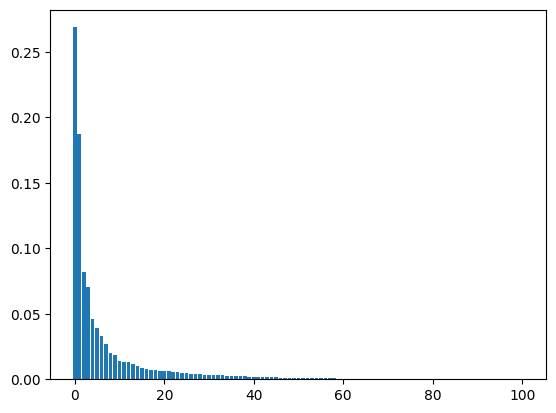

In [52]:
plt.bar(range(N_variables), PCA_Data.explained_variance_ratio_)

Then, let's save the rounded values with 4 decimals of the estimated weights for each variable in every eigenvector produced by PCA

In [53]:
AbsCompsPCA = np.abs(PCA_Data.components_)
IndexMaxVals_Vectors = np.argmax(AbsCompsPCA, axis=0)

And for more insight of these components, let's calculate how many of these we need to considere to represent the 85%, 90% and 95% of the total variance of the dataset.

In [54]:
def Find_NumCompsByPercent(Percent):
    if isinstance(Percent, float):
        N = 1
        while True:
            SumVar = PCA_Data.explained_variance_ratio_[:N].sum()
            
            if SumVar >= Percent:
                return (N, SumVar)
            else:
                N += 1

In [55]:
Percents = [0.85, 0.90, 0.95]
Num_SumVar = Find_NumCompsByPercent(Percents)

We got that with the first 15, 22 and 33 components we have an 85%, 90% and 95% of the variance respectively. So then, we will select only the maximum absolute weights of the first 15 or less non-repeated components.

In [56]:
Prior_VarComponents = set(IndexMaxVals_Vectors[:22])
Prior_VarComponents, len(Prior_VarComponents)

({4, 22, 23, 35, 44, 47, 51, 55, 67, 75, 80, 82, 84, 88, 91, 94, 98}, 17)

Now let's generate a _FinalData_ DataFrame with these columns indexes

In [57]:
FinalData = dict()
for index, column in enumerate(NewData.columns):
    if index in Prior_VarComponents:
        FinalData[column] = NewData.loc[:, column].to_numpy()

FinalData = pd.DataFrame(FinalData)
FinalData["ViolentCrimesPerPop"] = NewData.ViolentCrimesPerPop

FinalData

,racePctAsian,blackPerCap,indianPerCap,PctEmplProfServ,PctKids2Par,PctWorkMomYoungKids,NumImmig,PctImmigRec10,PctPersOwnOccup,PctVacMore6Mos,OwnOccMedVal,RentLowQ,RentHighQ,MedOwnCostPctIncNoMtg,PctForeignBorn,PctSameCity85,PctUsePubTrans,ViolentCrimesPerPop
0,0.12,0.32,0.27,0.41,0.59,0.74,0.03,0.39,0.55,0.26,0.19,0.36,0.38,0.25,0.12,0.51,0.20,0.20
1,0.45,0.33,0.16,0.15,0.47,0.46,0.01,0.63,0.26,0.25,0.20,0.42,0.40,0.18,0.21,0.60,0.45,0.67
2,0.17,0.27,0.07,0.29,0.44,0.71,0.00,0.19,0.42,0.30,0.17,0.27,0.27,0.28,0.14,0.67,0.02,0.43
3,0.12,0.39,0.16,0.45,0.54,0.85,0.02,0.31,0.94,0.47,0.21,0.75,0.77,0.47,0.19,0.64,0.28,0.12
4,0.09,0.28,0.00,0.38,0.91,0.40,0.00,0.27,0.89,0.55,0.31,0.40,0.38,0.21,0.11,0.61,0.02,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.12,0.27,0.00,0.68,0.68,0.78,0.01,0.47,0.55,0.21,0.22,0.45,0.41,0.39,0.22,0.48,0.05,0.09
1990,0.83,0.26,0.18,0.41,0.63,0.32,0.05,0.67,0.12,0.13,0.37,0.54,0.61,0.31,0.53,0.10,0.20,0.45
1991,0.04,0.25,0.19,0.40,0.42,0.38,0.06,0.26,0.38,0.45,0.32,0.28,0.39,0.53,0.25,0.79,0.18,0.23
1992,0.22,0.29,0.20,0.57,0.65,0.57,0.06,0.49,0.39,0.34,0.49,0.58,0.75,0.40,0.45,0.59,0.33,0.19


As final step, let's generate a DataFrame with logaritmic transformation of the form
$$ \text{Transformed Data} = \log{(1 + \text{Data} - \text{min(Data)})}$$

In [58]:
LogData = dict()
for column in FinalData.columns:
    LogData[column] = np.log10((1.0 + FinalData[column] - FinalData[column].min()).to_numpy())

LogData = pd.DataFrame(LogData)
LogData.to_csv("LogFinalData.csv")
LogData

,racePctAsian,blackPerCap,indianPerCap,PctEmplProfServ,PctKids2Par,PctWorkMomYoungKids,NumImmig,PctImmigRec10,PctPersOwnOccup,PctVacMore6Mos,OwnOccMedVal,RentLowQ,RentHighQ,MedOwnCostPctIncNoMtg,PctForeignBorn,PctSameCity85,PctUsePubTrans,ViolentCrimesPerPop
0,0.049218,0.120574,0.103804,0.149219,0.201397,0.240549,0.012837,0.143015,0.190332,0.100371,0.075547,0.133539,0.139879,0.096910,0.049218,0.178977,0.079181,0.079181
1,0.161368,0.123852,0.064458,0.060698,0.167317,0.164353,0.004321,0.212188,0.100371,0.096910,0.079181,0.152288,0.146128,0.071882,0.082785,0.204120,0.161368,0.222716
2,0.068186,0.103804,0.029384,0.110590,0.158362,0.232996,0.000000,0.075547,0.152288,0.113943,0.068186,0.103804,0.103804,0.107210,0.056905,0.222716,0.008600,0.155336
3,0.049218,0.143015,0.064458,0.161368,0.187521,0.267172,0.008600,0.117271,0.287802,0.167317,0.082785,0.243038,0.247973,0.167317,0.075547,0.214844,0.107210,0.049218
4,0.037426,0.107210,0.000000,0.139879,0.281033,0.146128,0.000000,0.103804,0.276462,0.190332,0.117271,0.146128,0.139879,0.082785,0.045323,0.206826,0.008600,0.012837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.049218,0.103804,0.000000,0.225309,0.225309,0.250420,0.004321,0.167317,0.190332,0.082785,0.086360,0.161368,0.149219,0.143015,0.086360,0.170262,0.021189,0.037426
1990,0.262451,0.100371,0.071882,0.149219,0.212188,0.120574,0.021189,0.222716,0.049218,0.053078,0.136721,0.187521,0.206826,0.117271,0.184691,0.041393,0.079181,0.161368
1991,0.017033,0.096910,0.075547,0.146128,0.152288,0.139879,0.025306,0.100371,0.139879,0.161368,0.120574,0.107210,0.143015,0.184691,0.096910,0.252853,0.071882,0.089905
1992,0.086360,0.110590,0.079181,0.195900,0.217484,0.195900,0.025306,0.173186,0.143015,0.127105,0.173186,0.198657,0.243038,0.146128,0.161368,0.201397,0.123852,0.075547


## Exploratory Data Analysis

<AxesSubplot: >

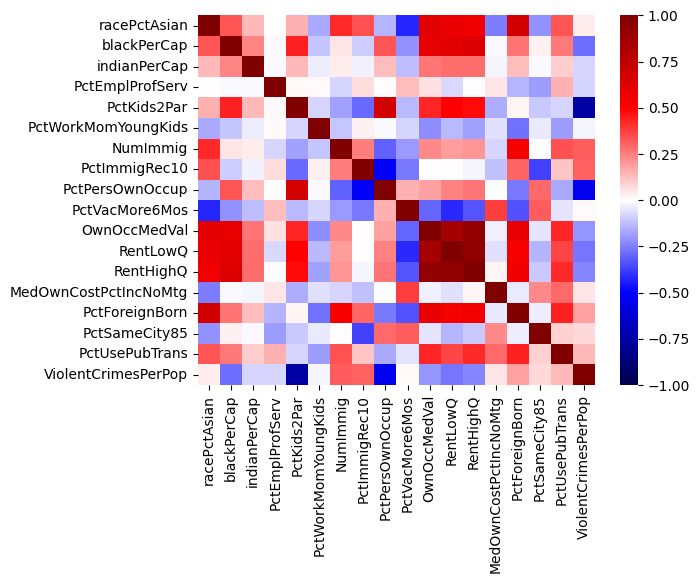

In [59]:
CorrMap = LogData.corr()

sns.heatmap(CorrMap, vmin=-1, vmax=1, cmap="seismic", annot=False)